<a href="https://colab.research.google.com/github/Deca97/Spam_Email_Classification/blob/main/Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classificazione Email Spam

1. **Caricamento e Esplorazione dei Dati**

* **Caricamento:** il dataset CSV contenente due colonne: 'text' (contenente il testo delle email) e 'label' (contenente le etichette 'spam' o 'ham').

* **Esplorazione**: Viene mostrata la distribuzione delle etichette (spam/ham) e visualizzata il numero di esempi per ciascuna etichetta.



2. **Pre-processamento del Testo**

* **Lemmatizzazione:** ridurre le parole alla loro forma base.

* **Rimozione stopwords:** Parole comuni che non contribuiscono alla semantica.

* **Rimozione punteggiatura.**




In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_distances
from spacy.matcher import Matcher

# Caricamento dataset
df = pd.read_csv("/spam_dataset.csv")


print(df['label'].value_counts())
print('\n')
print(df['text'].head(10))
print('\n')
print(df['text'].loc[0])





label
ham     3672
spam    1499
Name: count, dtype: int64


0    Subject: enron methanol ; meter # : 988291\nth...
1    Subject: hpl nom for january 9 , 2001\n( see a...
2    Subject: neon retreat\nho ho ho , we ' re arou...
3    Subject: photoshop , windows , office . cheap ...
4    Subject: re : indian springs\nthis deal is to ...
5    Subject: ehronline web address change\nthis me...
6    Subject: spring savings certificate - take 30 ...
7    Subject: looking for medication ? we ` re the ...
8    Subject: noms / actual flow for 2 / 26\nwe agr...
9    Subject: nominations for oct . 21 - 23 , 2000\...
Name: text, dtype: object


Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


0    enron methanol meter follow note give monday p...
1    hpl nom january attached file hplnol xls hplno...
2    neon retreat ho ho ho wonderful time year neon...
3    photoshop windows office cheap main trending a...
4    indian spring deal book teco pvr revenue under...
Name: cleaned_text, dtype: object
Distribuzione delle etichette:
label
ham     3672
spam    1499
Name: count, dtype: int64


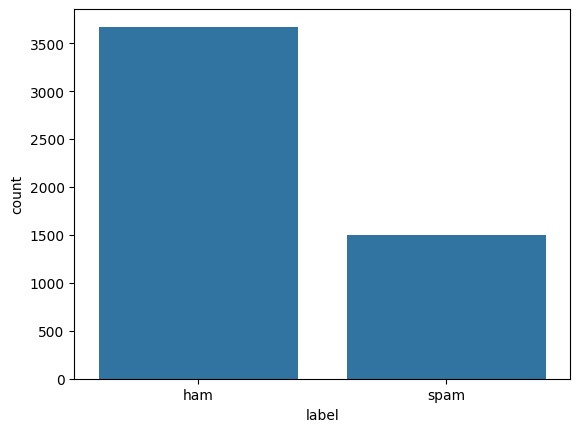

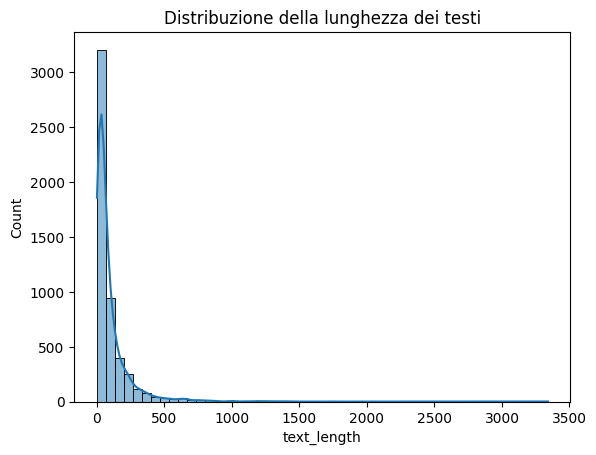

0    enron methanol meter follow note give monday p...
1    hpl nom january attached file hplnol xls hplno...
2    neon retreat ho ho ho wonderful time year neon...
3    photoshop windows office cheap main trending a...
4    indian spring deal book teco pvr revenue under...
5    ehronline web address change message intend eh...
6    spring saving certificate save use customer ap...
7    look medication ` good source difficult materi...
8    nom actual flow agree forward melissa jones te...
9     nomination oct attached file hplnl xls hplnl xls
Name: cleaned_text, dtype: object


In [ ]:

# Funzione per il pre-processing del testo
def preprocess_text(text, nlp):

    text = text.lower().replace("subject:", "").replace("\n", " ").strip()


    doc = nlp(text)
    # Lemmatizzazione e rimozione stopwords/punteggiatura
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num])



# Carica il modello di spaCy
nlp = spacy.load("en_core_web_sm")

# Applicare il pre-processing al testo
df['cleaned_text'] = df['text'].apply(lambda x: preprocess_text(x, nlp))

print(df['cleaned_text'].head())

# Esplorazione dei dati
print("Distribuzione delle etichette:")
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.show()

# Lunghezza media dei testi
df['text_length'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribuzione della lunghezza dei testi")
plt.show()

print(df['cleaned_text'].head(10))


3. **Creazione del Modello di Classificazione SPAM**


* **Vettorizzazione**: TfidfVectorizer: Converte il testo in una matrice numerica che rappresenta il peso di ciascuna parola nel testo.

* **Training:** Ricerca del miglior classificatore attraverso RandomSearch.

* **Predizione:** Il modello addestrato viene utilizzato per fare previsioni sui dati di test.

* **Valutazione**: Classification report (precisione, recall, F1-score) e la precisione (accuracy) del modello sui dati di test.


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd

# Caricamento dati
X = df['cleaned_text']
y = df['label']

# Divisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Definizione del vettorizzatore
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, lowercase=True)

# Definizione dei modelli
nb_model = MultinomialNB()
mlp_model = MLPClassifier(max_iter=500)

# Definizione della pipeline con undersampling o oversampling
pipeline = ImbPipeline([
    ('vectorizer', vectorizer),
    ('sampling', SMOTE()),
    ('classifier', nb_model)
])

# Definizione dei parametri per la ricerca randomizzata
param_grid = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.01, 0.1, 1.0],
        'sampling': [None, SMOTE(), RandomUnderSampler()]
    },
    {
        'classifier': [MLPClassifier(max_iter=500)],
        'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'sampling': [None, SMOTE(), RandomUnderSampler()]
    }
]

# Ricerca randomizzata
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=10, cv=3, n_jobs=-1, scoring='f1_weighted', random_state=42)
random_search.fit(X_train, y_train)

# Stampa dei migliori risultati per ogni combinazione di parametri
print("\n--- BEST PARAMETERS AND SCORES ---\n")
cv_results = random_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"F1 score: {mean_score:.4f} - Params: {params}")

# Miglior modello
best_model = random_search.best_estimator_
print("\nBest Model:", best_model)

# Predizione sui dati di test
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Valutazione dei risultati
print("\n--- TRAINING SET REPORT ---\n")
print(classification_report(y_train, y_train_pred))

print("\n--- TEST SET REPORT ---\n")
print(classification_report(y_test, y_test_pred))




--- BEST PARAMETERS AND SCORES ---

F1 score: 0.9664 - Params: {'sampling': None, 'classifier__alpha': 0.01, 'classifier': MultinomialNB()}
F1 score: 0.9644 - Params: {'sampling': SMOTE(), 'classifier__alpha': 0.01, 'classifier': MultinomialNB()}
F1 score: 0.9466 - Params: {'sampling': RandomUnderSampler(), 'classifier__alpha': 1.0, 'classifier': MultinomialNB()}
F1 score: 0.9503 - Params: {'sampling': RandomUnderSampler(), 'classifier__alpha': 0.1, 'classifier': MultinomialNB()}
F1 score: 0.9612 - Params: {'sampling': None, 'classifier__alpha': 0.1, 'classifier': MultinomialNB()}
F1 score: 0.9817 - Params: {'sampling': SMOTE(), 'classifier__hidden_layer_sizes': (100,), 'classifier': MLPClassifier(max_iter=500)}
F1 score: 0.9812 - Params: {'sampling': SMOTE(), 'classifier__hidden_layer_sizes': (100, 50), 'classifier': MLPClassifier(max_iter=500)}
F1 score: 0.9831 - Params: {'sampling': None, 'classifier__hidden_layer_sizes': (100, 50), 'classifier': MLPClassifier(max_iter=500)}
F1 sco

Tutte le combinazioni di parametri di entrambi i modelli hanno ottenuto ottimi risultati nel classificare i messaggi "ham" e "spam".

La precisione, il recall e l'F1-score sono tutti molto alti, indicando che il modello è altamente efficiente nel distinguere tra messaggi rilevanti e messaggi indesiderati.

I risultati sono ottimi sia sul trainong che sul test set, indicando assenza di overfitting.

5. **Estrazione dei Topics**

* Scoprire gli argomenti principali (topics) all'interno delle email spam.

* Estrarre le parole principali che caratterizzano ogni topic.

* Calcolo della distanza tra i topics.


--- TOPICS IDENTIFICATI ---

# Topic 1
- Parole chiave: http, say, cialis, soft, com, s, rolex, tab, call, good
- Pesi: 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002

# Topic 2
- Parole chiave: s, com, www, e, computron, $, message, remove, contact, http
- Pesi: 0.01, 0.01, 0.007, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.004

# Topic 3
- Parole chiave: $, pill, price, s, http, save, good, t, adobe, software
- Pesi: 0.024, 0.007, 0.007, 0.005, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003

# Topic 4
- Parole chiave: =, font, td, http, height, d, width, size, align, com
- Pesi: 0.091, 0.016, 0.015, 0.013, 0.011, 0.011, 0.009, 0.008, 0.007, 0.007

# Topic 5
- Parole chiave: |, company, s, statement, stock, information, security, $, investment, report
- Pesi: 0.017, 0.013, 0.009, 0.007, 0.006, 0.005, 0.005, 0.005, 0.005, 0.004



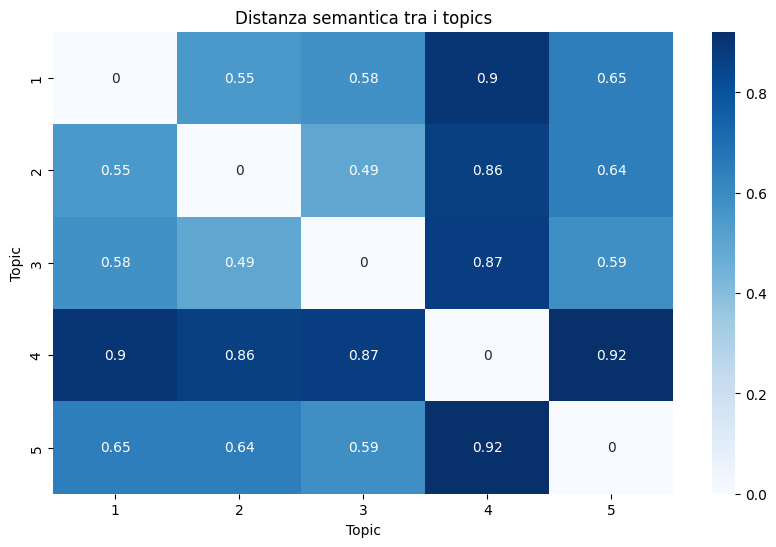

In [ ]:
from gensim import corpora
from gensim.models import LdaModel

# Estrazione email SPAM
spam_texts = df[df['label'] == 'spam']['cleaned_text']

# Converti i testi puliti in liste di token
spam_tokens = [text.split() for text in spam_texts]

# Crea il dizionario e il corpus
dictionary = corpora.Dictionary(spam_tokens)
corpus = [dictionary.doc2bow(text) for text in spam_tokens]

# Addestramento del modello LDA
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

# Estrazione dei topics
topics = lda_model.print_topics(num_words=10)


print("\n--- TOPICS IDENTIFICATI ---\n")
for topic in topics:
    topic_id, topic_terms = topic
    terms = topic_terms.split(' + ')
    words = [term.split('*"')[1].replace('"', '') for term in terms]
    weights = [float(term.split('*')[0]) for term in terms]
    print(f"# Topic {topic_id + 1}")
    print(f"- Parole chiave: {', '.join(words)}")
    print(f"- Pesi: {', '.join(map(str, weights))}")
    print()

# 3. Calcolare la distanza semantica tra i topics (eterogeneità dei contenuti)
topic_distances = lda_model.get_topics()
topic_distances_cosine = cosine_distances(topic_distances)

plt.figure(figsize=(10, 6))
sns.heatmap(topic_distances_cosine, annot=True, cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.title("Distanza semantica tra i topics")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()


I 5 topic sembrano essere abbastanza eterogenei tra loro, con una distanza semantica minima di 0.49 tra i topic 2 e 3.

7. **Estrazione delle Organizzazioni dalle Email Non Spam**

* Estrazione testi delle email etichettate come ham.

* Identificazioni entità come organizzazioni nelle email non spam.


--- ORGANIZZAZIONI MENZIONATE ---

Le seguenti organizzazioni sono state trovate più frequentemente nelle email NON SPAM:
- tenaska: 207 occorrenze
- enron: 190 occorrenze
- chokshi corp: 95 occorrenze
- pat clynes corp enron: 90 occorrenze
- exxon: 76 occorrenze
- acton corp enron: 67 occorrenze
- parker corp enron: 50 occorrenze
- cec: 48 occorrenze
- chokshi corp enron: 45 occorrenze
- hplc: 39 occorrenze


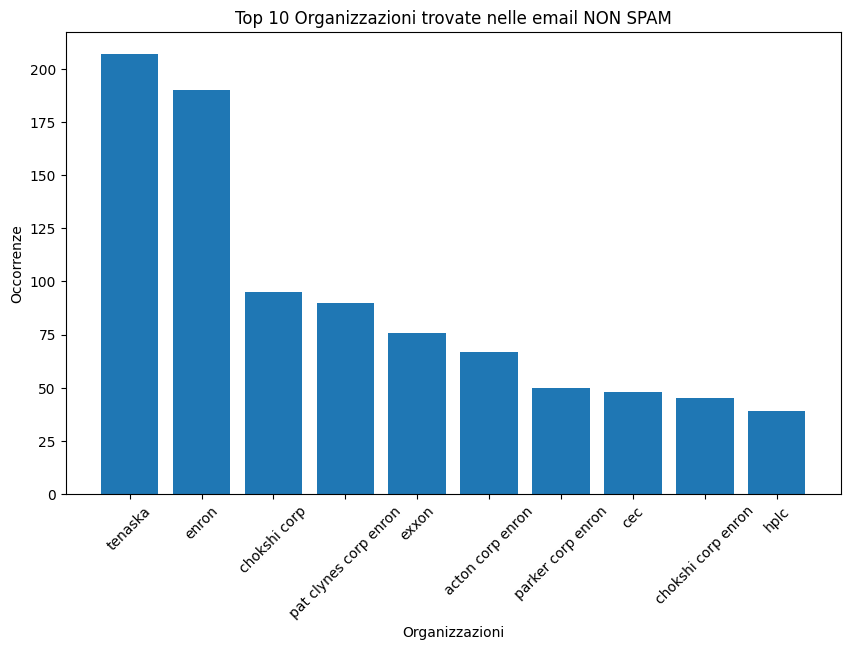

In [ ]:
from collections import Counter


# Estrazione Organizzazioni dalle email NON SPAM
non_spam_texts = df[df['label'] == 'ham']['cleaned_text']
organizations = []

for text in non_spam_texts:
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "ORG":
            organizations.append(ent.text)

# Conteggio delle organizzazioni più frequenti
org_counts = Counter(organizations)

# Selezione delle organizzazioni più frequenti
top_organizations = org_counts.most_common(10)

print("\n--- ORGANIZZAZIONI MENZIONATE ---\n")
if top_organizations:
    print("Le seguenti organizzazioni sono state trovate più frequentemente nelle email NON SPAM:")
    for org, count in top_organizations:
        print(f"- {org}: {count} occorrenze")
    plt.figure(figsize=(10, 6))
    plt.bar([org for org, _ in top_organizations], [count for _, count in top_organizations])
    plt.xlabel("Organizzazioni")
    plt.ylabel("Occorrenze")
    plt.title("Top 10 Organizzazioni trovate nelle email NON SPAM")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Nessuna organizzazione trovata nelle email NON SPAM.")

